In [ ]:
!pip install keras_metrics owlready2 fasttext

from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Création fichier paires négatives


In [ ]:
def nettoyer_unicode(c):
    liste_codes =  {
        'Ã\xa0': 'à',
        'Ã€': 'À',
        'Ã¢': 'â',
        'ã': 'â',
        'Ã‚': 'Â',
        'Ã©': 'é',
        'Ã©': 'é',
        'ã‰': 'é',
        'ãƒâ©': 'é',
        'Ã\x89': 'É',
        'Ã\xa8': 'è',
        'Ã\xaa': 'ê',
        'Ã\x8a': 'Ê', 
        'Ã¨': 'ê',       
        'Ã«': 'ë',
        'Ã®':'î',
        'Ã\x8e':'Î',        
        'Ã¯': 'ï', 
        'Ã´': 'ô',
        'Ã\x94': 'Ô',
        'Ã¹': 'ù', 
        'Ã»': 'û',
        'Å\x93': 'œ', 
        'Â«': '«',
        'Â»': '»',
        'Ã§': 'ç',
        'Ã\x87': 'Ç',
        'Âº': 'º',
        'â€™': '’',
        'â\x80\x99': '’',
        'â\x80\xa6' : '…',
    }
    
    for code in liste_codes:
        c = c.replace(code,liste_codes[code])
    return c

In [ ]:
import csv 
import numpy as np

paires_diff = []
with open("/content/drive/My Drive/Colab Notebooks/neg_results.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
      titre1_clean = nettoyer_unicode(row['title_raw1'])
      titre2_clean = nettoyer_unicode(row['title_raw2'])
      if (titre1_clean != titre2_clean): 
          paires_diff.append([titre1_clean, titre2_clean])
    print(len(paires_diff))
    np.save("/content/drive/My Drive/Colab Notebooks/paires_neg", paires_diff)

95882


In [ ]:
import numpy as np
from sklearn.utils import shuffle

#Paires positives
paires_pos = np.load("/content/drive/My Drive/Colab Notebooks/paires_pos.npy", allow_pickle = True)
# paires_pos = np.load("Desktop/paires_pos.npy", allow_pickle = True)

#Paires negatives
paires_neg = np.load("/content/drive/My Drive/Colab Notebooks/paires_neg.npy", allow_pickle = True)
# paires_neg = np.load("Desktop/paires_neg.npy", allow_pickle = True)

print(len(paires_pos), "paires positives")
print(len(paires_neg), "paires negatives")

#training
rand_pos_indices = np.random.choice(paires_pos.shape[0], 8250, replace=False)
training_data_pos = paires_pos[rand_pos_indices]
rand_neg_indices = np.random.choice(paires_neg.shape[0], 8250, replace=False)
training_data_neg = paires_neg[rand_neg_indices]

#training data
# formatter en X et Y pour CNN
id = []
titre1 = []
titre2 = []
for pair in training_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in training_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
train_data = shuffle(titre1, titre2, id)

#test
#get remaining pairs
remaining_pos_indices = np.array([x for x in np.arange(paires_pos.shape[0]) if not np.isin(x, rand_pos_indices)])
remaining_neg_indices = np.array([x for x in np.arange(paires_neg.shape[0]) if not np.isin(x, rand_neg_indices)])
remaining_pos = paires_pos[remaining_pos_indices]
remaining_neg = paires_neg[remaining_neg_indices]

#sélection aléatoire 500 paires positives et négatives
test_indices_pos = np.random.choice(remaining_pos.shape[0], 500, replace=False)
test_data_pos = remaining_pos[test_indices_pos]
test_indices_neg = np.random.choice(remaining_neg.shape[0], 500, replace=False)
test_data_neg = remaining_neg[test_indices_neg]

id = []
titre1 = []
titre2 = []
for pair in test_data_neg:
  id.append(0)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
for pair in test_data_pos:
  id.append(1)
  titre1.append(nettoyer_unicode(pair[0].lower()))
  titre2.append(nettoyer_unicode(pair[1].lower()))
test_data = shuffle(titre1, titre2, id)


8950 paires positives
95882 paires negatives


Récupérer FastText

On réalise la tokenisation du texte

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(filters=',"!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', char_level=True )
tokenizer.fit_on_texts(train_data[0] + train_data[1])
# tokenizer.fit_on_sequence

len_seq = 150
len_dict = len(tokenizer.word_counts) + 1
print(tokenizer.word_index)

#training data
train_data[0] = pad_sequences(tokenizer.texts_to_sequences(train_data[0]), maxlen=len_seq)
train_data[1] = pad_sequences(tokenizer.texts_to_sequences(train_data[1]), maxlen=len_seq)
print(train_data[0])
#concatenate word vectors
conc = []
for index, val in enumerate(train_data[0]):
  conc.append(np.concatenate([train_data[0][index], train_data[1][index]]))
train_data.append(conc)

#testing data
test_data[0] = pad_sequences(tokenizer.texts_to_sequences(test_data[0]), maxlen=len_seq)
test_data[1] = pad_sequences(tokenizer.texts_to_sequences(test_data[1]), maxlen=len_seq)

#concatenate word vectors
conc = []
for index, val in enumerate(test_data[0]):
  conc.append(np.concatenate([test_data[0][index], test_data[1][index]]))
test_data.append(conc)


{' ': 1, 'e': 2, 'l': 3, 's': 4, 'a': 5, 'r': 6, 'i': 7, 'o': 8, 'n': 9, 't': 10, 'u': 11, 'd': 12, 'm': 13, 'c': 14, 'p': 15, 'é': 16, 'v': 17, 'g': 18, 'h': 19, 'b': 20, 'f': 21, "'": 22, '-': 23, 'è': 24, 'q': 25, 'j': 26, 'y': 27, ',': 28, 'x': 29, '1': 30, '2': 31, 'k': 32, 'à': 33, '.': 34, '!': 35, 'ê': 36, '3': 37, '0': 38, '(': 39, ')': 40, 'z': 41, 'â': 42, '/': 43, '4': 44, 'º': 45, ':': 46, 'ô': 47, '5': 48, '9': 49, '°': 50, '7': 51, '6': 52, 'î': 53, 'w': 54, '8': 55, ';': 56, 'ë': 57, 'œ': 58, 'ï': 59, '?': 60, '[': 61, ']': 62, 'ç': 63, '’': 64, 'û': 65, '&': 66, 'ã': 67, '#': 68, '=': 69, 'ù': 70, '\xa0': 71, '\x80': 72, '"': 73, 'ü': 74, '–': 75, 'í': 76, '…': 77, '«': 78, '»': 79, '¼': 80, '@': 81, 'á': 82, 'å': 83, '\x92': 84, '+': 85, '_': 86, 'ö': 87, '\n': 88, '\x88': 89, '\xad': 90, 'ä': 91, '\x84': 92, '¶': 93, 'ñ': 94, 'ó': 95, '½': 96, '*': 97, '£': 98, '¿': 99, '̂': 100, '%': 101, '²': 102, 'š': 103, '³': 104, 'ø': 105, '¢': 106}
[[ 0  0  0 ... 12  2  6]
 [ 

Création du modèle

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from time import time
import tensorflow.keras as keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GaussianNoise, BatchNormalization, Bidirectional, TimeDistributed
from keras.layers import Conv2D, AveragePooling1D, MaxPooling2D, Conv1D, MaxPooling1D, Embedding, LSTM
from keras_metrics import precision, recall, f1_score, binary_precision, binary_f1_score, binary_recall
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from nltk.metrics import edit_distance
from keras.utils import plot_model
import matplotlib.pyplot as plt

def createLSTM():
  model = Sequential([
    Embedding(128, 300, input_length=len_seq * 2),

    # Embedding(m_embedding.shape[0], 300, input_length=len_seq * 2, weights=[m_embedding]),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)])
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def createCNN():
  model = Sequential()
  model.add(Embedding(128, 300, input_length=len_seq*2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(300))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))  
  
  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def create_model():
  model = Sequential()
  model.add(Embedding(128, 300, input_length=len_seq*2))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(AveragePooling1D(pool_size=2, padding='same'))
  
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))
  model.add(Conv1D(64, 5, padding='same'))
  model.add(Activation('relu'))

  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(500))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy', binary_precision(), binary_recall(), binary_f1_score()])
  return model

def train(model, train_data):
    nb_examples = len(train_data)
    x_train = np.array(train_data[3])
    y_train = np.array(train_data[2])

    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='min')
    cp = ModelCheckpoint("model.h5", save_best_only=True, monitor='val_loss', mode='min')

    # neg_weight = 40

    history = model.fit(x=x_train,
              y=y_train,
              epochs=100,
              batch_size=64,
              validation_split=0.1,
              # class_weight={0: neg_weight, 1: 1},
              callbacks=[es, cp])
    
    print(history.history.keys())
    # history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for precision
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('model precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def test_model(model, test_datasets):
    for i, ds in enumerate(test_datasets):
        x_test = np.array(test_data[3])
        y_test = np.array(test_data[2])

        preds = model.predict_on_batch(x_test)
        preds = [1 if preds[i][0] > 0.1 else 0 for i in range(preds.shape[0])]
        tp_ = tp(preds, y_test)
        fp_ = fp(preds, y_test)
        fn_ = fn(preds, y_test)
        tn_ = tn(preds, y_test)
        a = accuracy(tp_, tn_, fp_, fn_)
        p = precision(tp_, fp_)
        r = recall(tp_, fn_)
        f1 = f1_score(p, r)

        p_n = precision_negative(tn_, fn_)
        r_n = recall_negative(tn_, fp_)
        f1_n = f1_score_negative(p_n, r_n)

        print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"tn: {tn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
        print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
        print(f"accuracy: {a} ")
        print('positives')
        print(f"precision: {p}, recall: {r}, f1: {f1}")
        print('negatives')
        print(f"precision: {p_n}, recall: {r_n}, f1: {f1_n}")
            
def tp(preds, targets):
    tp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 1])
    
    return tp

def fp(preds, targets):
    fp = len([1 for i in range(len(preds)) if preds[i] == 1 and targets[i] == 0])
    
    return fp

def tn(preds, targets):
    tn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 0])
    return tn

def fn(preds, targets):
    fn = len([1 for i in range(len(preds)) if preds[i] == 0 and targets[i] == 1])
    return fn

def accuracy(tp_, tn_, fp_, fn_):
    return (tp_ + tn_)/ (tp_ + tn_ + fp_ + fn_)
    
def accuracy_negative(tp_, tn_, fp_, fn_):
    return (tp_ + tn_)/ (tp_ + tn_ + fp_ + fn_)

def precision(tp_, fp_):    
    return tp_ / (tp_ + fp_)

def precision_negative(tn_, fn_):    
    return tn_ / (tn_ + fn_)

def recall(tp_, fn_):
    return tp_ / (tp_ + fn_)

def recall_negative(tn_, fp_):
    return tn_ / (tn_ + fp_)

def f1_score(p, r):
    return 2 * p * r / (p + r)


Epoch 1/100
233/233 [==============================] - 240s 1s/step - loss: 1.7541 - accuracy: 0.4984 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.2356 - val_accuracy: 0.5145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
233/233 [==============================] - 236s 1s/step - loss: 1.1462 - accuracy: 0.4984 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.0079 - val_accuracy: 0.5145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/100
233/233 [==============================] - 239s 1s/step - loss: 0.9550 - accuracy: 0.4984 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.8589 - val_accuracy: 0.5145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/100
233/233 [==============================] - 240s 1s/step - loss: 0.8168 - accuracy: 0.4984 - precision: 0.0000e+0

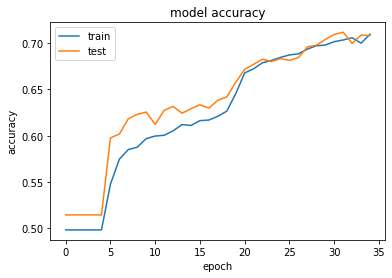

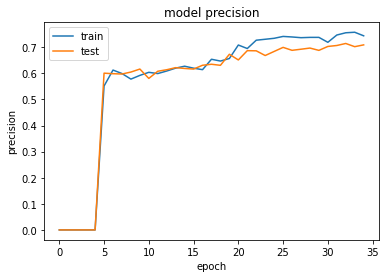

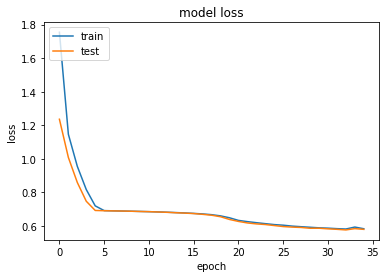

Epoch 1/100
233/233 [==============================] - 91s 389ms/step - loss: 0.6674 - accuracy: 0.6446 - precision: 0.6214 - recall: 0.6437 - f1_score: 0.6230 - val_loss: 0.6854 - val_accuracy: 0.5624 - val_precision: 0.5108 - val_recall: 0.8168 - val_f1_score: 0.6283
Epoch 2/100
233/233 [==============================] - 90s 386ms/step - loss: 0.6123 - accuracy: 0.6815 - precision: 0.7465 - recall: 0.5546 - f1_score: 0.6362 - val_loss: 0.6461 - val_accuracy: 0.6945 - val_precision: 0.7242 - val_recall: 0.5946 - val_f1_score: 0.6525
Epoch 3/100
233/233 [==============================] - 93s 400ms/step - loss: 0.5913 - accuracy: 0.6993 - precision: 0.7676 - recall: 0.5664 - f1_score: 0.6518 - val_loss: 0.5922 - val_accuracy: 0.7170 - val_precision: 0.7433 - val_recall: 0.6280 - val_f1_score: 0.6805
Epoch 4/100
233/233 [==============================] - 90s 388ms/step - loss: 0.5715 - accuracy: 0.7203 - precision: 0.7780 - recall: 0.6127 - f1_score: 0.6855 - val_loss: 0.5585 - val_accur

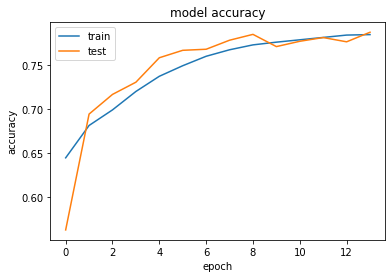

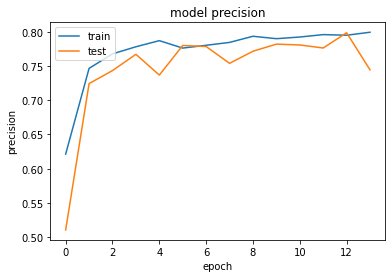

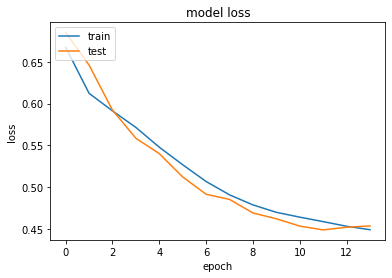

Epoch 1/100
233/233 [==============================] - 129s 554ms/step - loss: 0.6859 - accuracy: 0.6317 - precision: 0.5843 - recall: 0.4895 - f1_score: 0.5268 - val_loss: 0.6859 - val_accuracy: 0.6552 - val_precision: 0.7913 - val_recall: 0.4280 - val_f1_score: 0.5540
Epoch 2/100
233/233 [==============================] - 133s 569ms/step - loss: 0.5765 - accuracy: 0.7209 - precision: 0.7687 - recall: 0.6160 - f1_score: 0.6838 - val_loss: 0.6054 - val_accuracy: 0.7224 - val_precision: 0.8055 - val_recall: 0.5856 - val_f1_score: 0.6779
Epoch 3/100
233/233 [==============================] - 130s 557ms/step - loss: 0.5361 - accuracy: 0.7539 - precision: 0.7927 - recall: 0.6864 - f1_score: 0.7356 - val_loss: 0.5345 - val_accuracy: 0.7527 - val_precision: 0.8353 - val_recall: 0.6234 - val_f1_score: 0.7138
Epoch 4/100
233/233 [==============================] - 128s 551ms/step - loss: 0.5111 - accuracy: 0.7622 - precision: 0.7979 - recall: 0.7007 - f1_score: 0.7461 - val_loss: 0.6198 - val_a

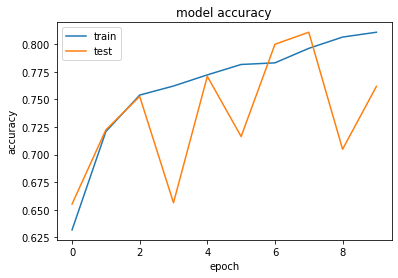

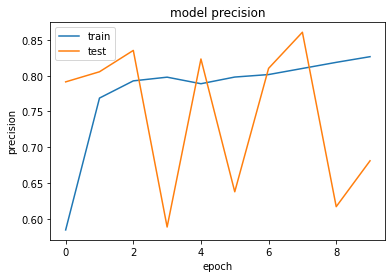

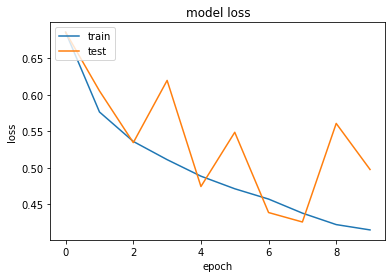

In [ ]:
if __name__ == '__main__':  

  # BiLSTM
  bilstm = createLSTM()
  train(bilstm, train_data)
  # test_model(bilstm, test_data)

  #CNN light
  cnn = createCNN()
  train(cnn, train_data)
  # test_model(cnn, test_data)

  #CNN ALexandre no weights
  model = create_model()
  train(model, train_data)
  # test_model(model, test_data)
  # model.save("model_test_full_2.h5")


In [ ]:
def test_print(model, data):
  # for i, ds in enumerate(data):
    x_test = np.array(test_data[3])
    y_test = np.array(test_data[2])

    preds = model.predict_on_batch(x_test)
    preds = [1 if preds[i][0] > 0.5 else 0 for i in range(preds.shape[0])]
    # print(preds)
    # print(test_data[2])
    tp_ = tp(preds, y_test)
    fp_ = fp(preds, y_test)
    fn_ = fn(preds, y_test)
    tn_ = tn(preds, y_test)
    a = accuracy(tp_, tn_, fp_, fn_)
    p = precision(tp_, fp_)
    r = recall(tp_, fn_)
    f1 = f1_score(p, r)

    p_n = precision_negative(tn_, fn_)
    r_n = recall_negative(tn_, fp_)
    f1_n = f1_score(p_n, r_n)

    print(f"tp: {tp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
    print(f"tn: {tn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
    print(f"fp: {fp_}, nb_pos: {len([1 for y in y_test if y == 1])}")
    print(f"fn: {fn_}, nb_neg: {len([1 for y in y_test if y == 0])}")
    print(f"accuracy: {a} ")
    print('positives')
    print(f"precision: {p}, recall: {r}, f1: {f1}")
    print('negatives')
    print(f"precision: {p_n}, recall: {r_n}, f1: {f1_n}")

print("BiLSTM")
test_print(bilstm, test_data)
print("CNN")
test_print(cnn, test_data)
print("CNN Alexandre")
test_print(model, test_data)


BiLSTM
tp: 327, nb_pos: 500
tn: 386, nb_neg: 500
fp: 114, nb_pos: 500
fn: 173, nb_neg: 500
accuracy: 0.713 
positives
precision: 0.7414965986394558, recall: 0.654, f1: 0.6950053134962806
negatives
precision: 0.6905187835420393, recall: 0.772, f1: 0.728989612842304
CNN
tp: 413, nb_pos: 500
tn: 349, nb_neg: 500
fp: 151, nb_pos: 500
fn: 87, nb_neg: 500
accuracy: 0.762 
positives
precision: 0.7322695035460993, recall: 0.826, f1: 0.7763157894736843
negatives
precision: 0.8004587155963303, recall: 0.698, f1: 0.7457264957264957
CNN Alexandre
tp: 455, nb_pos: 500
tn: 283, nb_neg: 500
fp: 217, nb_pos: 500
fn: 45, nb_neg: 500
accuracy: 0.738 
positives
precision: 0.6770833333333334, recall: 0.91, f1: 0.7764505119453925
negatives
precision: 0.8628048780487805, recall: 0.566, f1: 0.6835748792270532
